# SAM 2 (Segment Anything Model 2)

In [1]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [2]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 21.34 MiB/s, done.
Resolving deltas: 100% (381/381), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.6 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done


In [3]:
!pip install -q supervision jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.4/217.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.7 MB/s eta 0:00:00


In [4]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

In [ ]:
import cv2
import torch
import base64
import numpy as np
import supervision as sv
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
import requests
import io
import requests
from PIL import Image
import matplotlib.pyplot as plt

In [6]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [7]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

In [ ]:
image_url = "https://thumbs.dreamstime.com/z/tan-chihuahua-dog-very-happy-local-park-green-grass-looking-camera-smiling-tan-chihuahua-dog-very-happy-187052944.jpg?ct=jpeg"

response = requests.get(image_url)
response.raise_for_status() # Raise an exception for HTTP errors
image_bgr_data = np.frombuffer(response.content, np.uint8)
image_bgr = cv2.imdecode(image_bgr_data, cv2.IMREAD_COLOR)

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_generator = SAM2AutomaticMaskGenerator(sam2_model)
sam2_result = mask_generator.generate(image_rgb)

In [9]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
)

In [10]:
sam2_result_2 = mask_generator_2.generate(image_rgb)

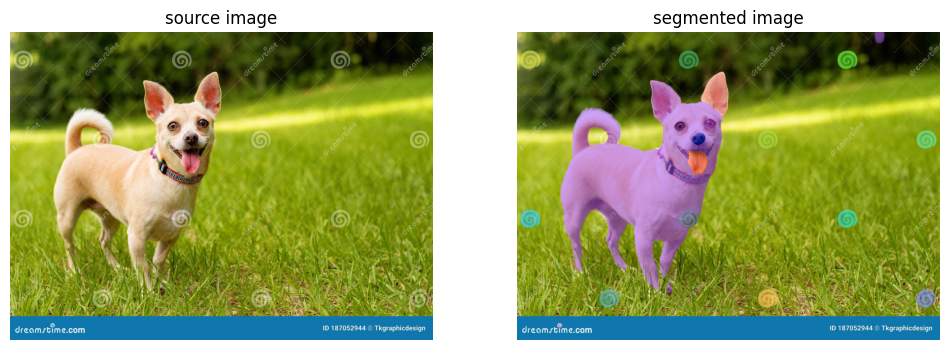

In [11]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

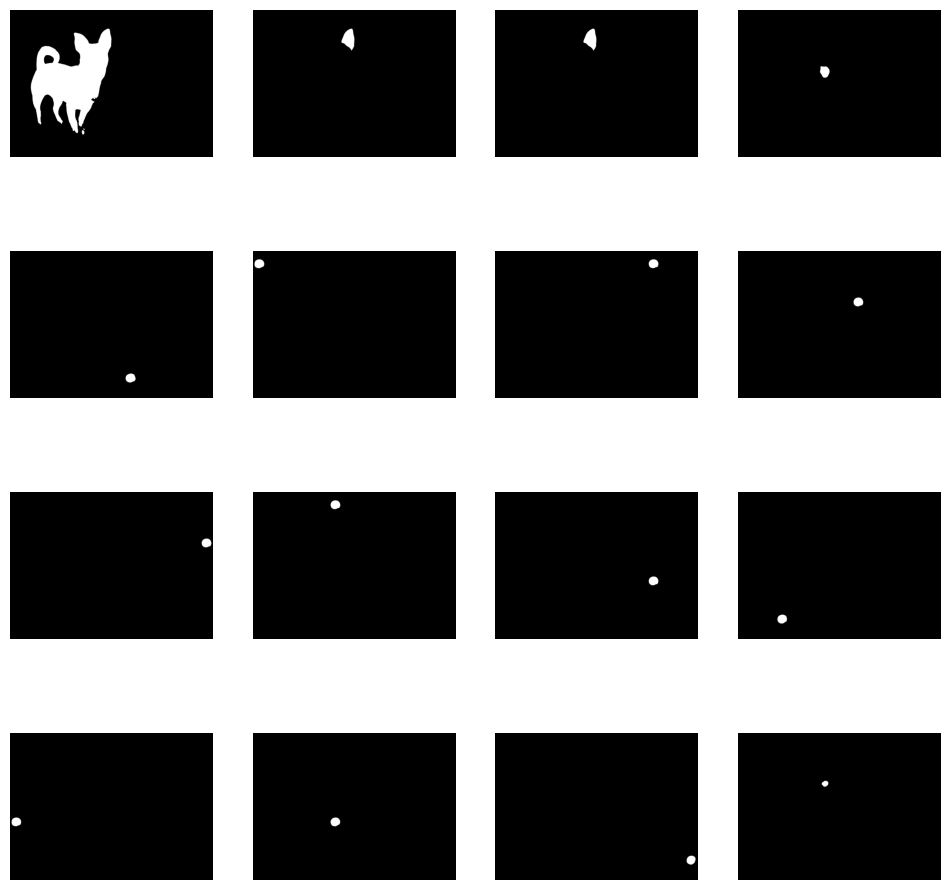

In [12]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam2_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks[:16],
    grid_size=(4, 4),
    size=(12, 12)
)

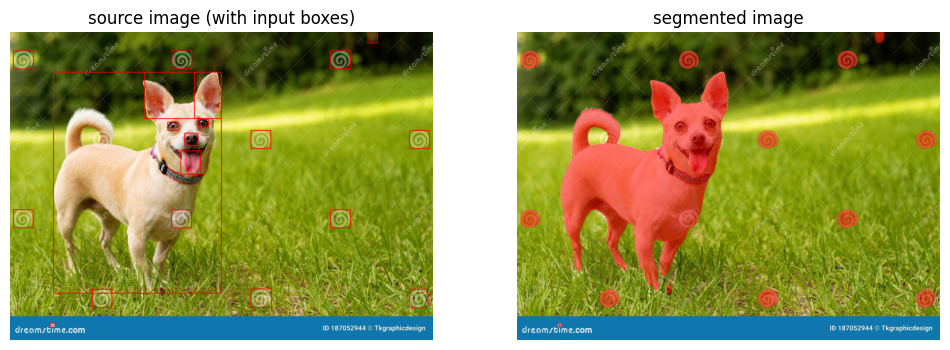

In [13]:
box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

combined_masks = detections.mask
bounding_boxes = detections.xyxy

if combined_masks.size > 0:
    detections_for_mask_annotation = sv.Detections(
        xyxy=sv.mask_to_xyxy(masks=combined_masks),
        mask=combined_masks
    )
else:
    detections_for_mask_annotation = sv.Detections(
        xyxy=np.array([]).reshape(0,4),
        mask=np.array([]).reshape(0,0,0)
    )

source_image = image_bgr.copy()
for box_coords in bounding_boxes:
    x1, y1, x2, y2 = box_coords
    temp_detections_for_box = sv.Detections(xyxy=np.array([[x1, y1, x2, y2]]))
    source_image = box_annotator.annotate(scene=source_image, detections=temp_detections_for_box)

segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections_for_mask_annotation)


sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image (with input boxes)', 'segmented image']
)

In [14]:
predictor = SAM2ImagePredictor(sam2_model)

In [21]:
image_url_target = "/content/067959af-dd31-4c86-a411-60fc01e17fc4 (1).jpg"
print(f"New target image URL: {image_url_target}")

New target image URL: /content/067959af-dd31-4c86-a411-60fc01e17fc4 (1).jpg


In [ ]:
# local files
image_bgr_target = cv2.imread(image_url_target)

if image_bgr_target is None:
    raise FileNotFoundError(f"Could not load image from {image_url_target}. Please ensure the file exists and the path is correct.")

target_image_rgb = cv2.cvtColor(image_bgr_target, cv2.COLOR_BGR2RGB)

print("Target image loaded successfully and converted to RGB.")

Target image loaded successfully and converted to RGB.


In [ ]:
source_pil_image = Image.fromarray(image_rgb)
target_pil_image = Image.fromarray(target_image_rgb)

if sam2_result:
    largest_mask_info = sorted(sam2_result, key=lambda x: x['area'], reverse=True)[0]
    segmented_mask = largest_mask_info['segmentation']
else:
    raise ValueError("No segmentation masks found in sam2_result for the source image.")

alpha_channel = (segmented_mask * 255).astype(np.uint8)
segmented_object_pil = Image.fromarray(image_rgb).convert("RGBA")
segmented_object_pil.putalpha(Image.fromarray(alpha_channel))

width, height = segmented_object_pil.size
new_width = int(width * 0.15)
new_height = int(height * 0.15)
segmented_object_pil = segmented_object_pil.resize((new_width, new_height), Image.LANCZOS)

blended_image_pil = target_pil_image.copy().convert("RGBA")
blended_image_pil.paste(segmented_object_pil, (200,150), segmented_object_pil)
blended_image = np.array(blended_image_pil.convert("RGB"))

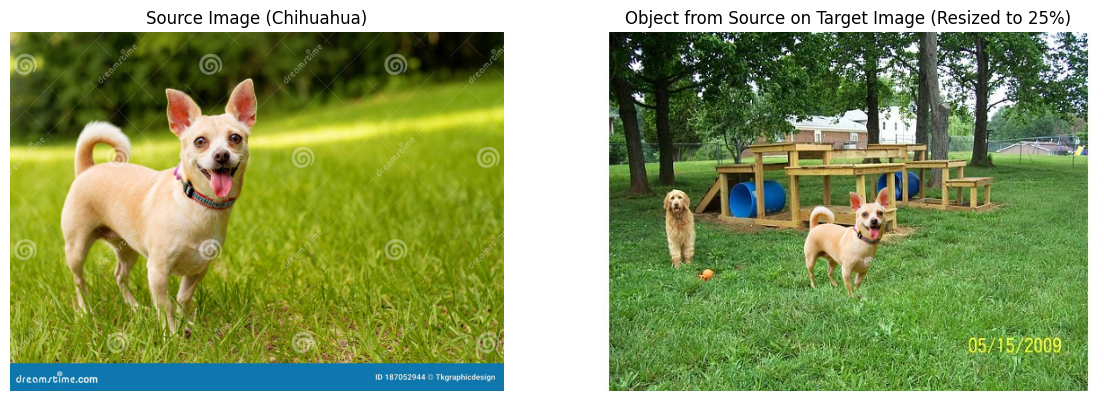

In [ ]:
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title('Source Image (Chihuahua)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(blended_image)
plt.title('Object from Source on Target Image (Resized to 25%)')
plt.axis('off')
plt.show()